Predicting Heart Disease 

Introduction

Heart disease is currently the leading cause of death from a non-transmissible source with 8.9 million people dying from it annually (Filate et al. 2003; Health Agency of Canada 2018). This is mainly due to a growing aging population making it so a larger portion of people are more prone to cardiovascular diseases (Health Agency of Canada 2018; Statista 2021). However, the disease takes years to develop and is very easily preventable by monitoring or reducing risk factors through various lifestyle changes such as eating a healthy diet, increasing physical activity, and limiting smoking and alcohol consumption (Statista 2021; Government of Canada, 2017). Therefore, early detection of risk factors can help prevent heart disease from developing, or can help prevent the progression of the disease. 

Hence, our research question is:
How can age, blood pressure, cholesterol, heart rate, and number of major blood vessels predict heart disease?

For this analysis we will be using the modified Cleveland dataset from the Heart Disease Data Set from the UCI Machine Learning Repository. The dataset consists of 15 different attributes as follows:

age: Age of person in years

sex: (1 = male, 0 = female)

cp_type: The types of chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)

rest_bp: Resting blood pressure (mm Hg on admission to the hospital)

chol: serum cholesterol in mg/dl

fbs: Fasting blood sugar (if > 120 mg/dl, 1 = true; 0 = false)

restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes’ criteria)

max_hr: Maximum heart rate achieved

eia: Exercise induced angina (1 = yes; 0 = no)

op: ST depression induced by exercise relative to rest (‘ST’ relates to positions on the ECG plot)

slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)

num_bv: The number of major vessels (0–3)

thal: A blood disorder called thalassemia (1 = normal; 2 = fixed defect; 3 = reversible defect)

class: With or without heart disease (buff = healthy, sick = heart disease)

health: Heart disease (0 = no, 1, 2, 3, 4 = yes)

To create our model we will be selecting age, resting blood pressure, max heart rate, cholesterol, and the number of major vessels for our predictors. Then we will be using the class as our predicted attribute. 


Exploratory Analysis

In [4]:
#Downloading the necessary packages.
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [6]:
#Setting the seed.
set.seed(1234)

#Dowloading the data from the web and reading it in R.
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod"
download.file (url,"cleve.mod" )
colnames <-c("age","sex","cp_type","rest_bp", "chol", 
             "fbs","restecg","max_hr","eia", 
             "op","slope","num_bv","thal","class","health") #Adding column names
clev_data <-read_delim("cleve.mod", skip=20, delim="   ", col_names = colnames) %>%
    mutate(class = as_factor(class)) %>% #Wrangling data and selecting columns to be used in prediction
    mutate(max_hr = as.numeric(max_hr))%>%
    mutate(num_bv = as.numeric(num_bv))%>%
    mutate(rest_bp = as.numeric(rest_bp)) %>%
    select(age, rest_bp, chol, max_hr, num_bv, class) %>%
    filter(class == "buff" | class == "sick")

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_character(),
  cp_type = col_character(),
  rest_bp = col_character(),
  chol = col_double(),
  fbs = col_character(),
  restecg = col_character(),
  max_hr = col_character(),
  eia = col_character(),
  op = col_character(),
  slope = col_character(),
  num_bv = col_character(),
  thal = col_character(),
  class = col_character(),
  health = col_character()
)

Warning message:
“Problem with `mutate()` input `num_bv`.
ℹ NAs introduced by coercion
ℹ Input `num_bv` is `as.numeric(num_bv)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


In [7]:
#Splitting the data into a training and a testing set.
#75% of the data will be randomly taken as training data.
clev_split <- initial_split(clev_data, prop = 0.75, strata = class)  
clev_train <- training(clev_split)   
clev_test <- testing(clev_split)
head(clev_train)

age,rest_bp,chol,max_hr,num_bv,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,0,buff
67,160,286,108,3,sick
67,120,229,129,2,sick
41,130,204,172,0,buff
57,120,354,163,0,buff
63,130,254,147,1,sick


In [15]:
#Visualizing the summary of the predictor variables.
summary(clev_train)
nrow(clev_train)

      age           rest_bp           chol           max_hr     
 Min.   :29.00   Min.   : 94.0   Min.   :131.0   Min.   : 71.0  
 1st Qu.:48.00   1st Qu.:120.0   1st Qu.:211.0   1st Qu.:136.0  
 Median :56.00   Median :130.0   Median :240.5   Median :154.0  
 Mean   :54.63   Mean   :132.2   Mean   :245.9   Mean   :150.0  
 3rd Qu.:61.00   3rd Qu.:140.0   3rd Qu.:273.0   3rd Qu.:165.8  
 Max.   :77.00   Max.   :192.0   Max.   :417.0   Max.   :202.0  
                                                                
     num_bv         class    
 Min.   :0.0000   buff :123  
 1st Qu.:0.0000   sick :103  
 Median :0.0000    buff:  0  
 Mean   :0.6471    sick:  0  
 3rd Qu.:1.0000              
 Max.   :3.0000              
 NA's   :5                   

[1] 226

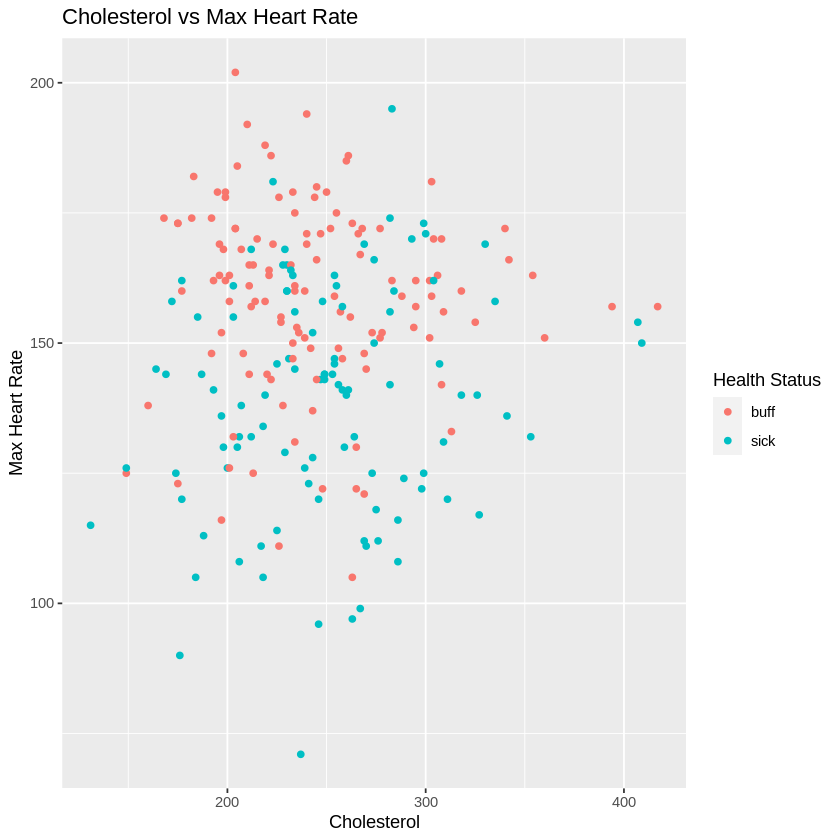

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



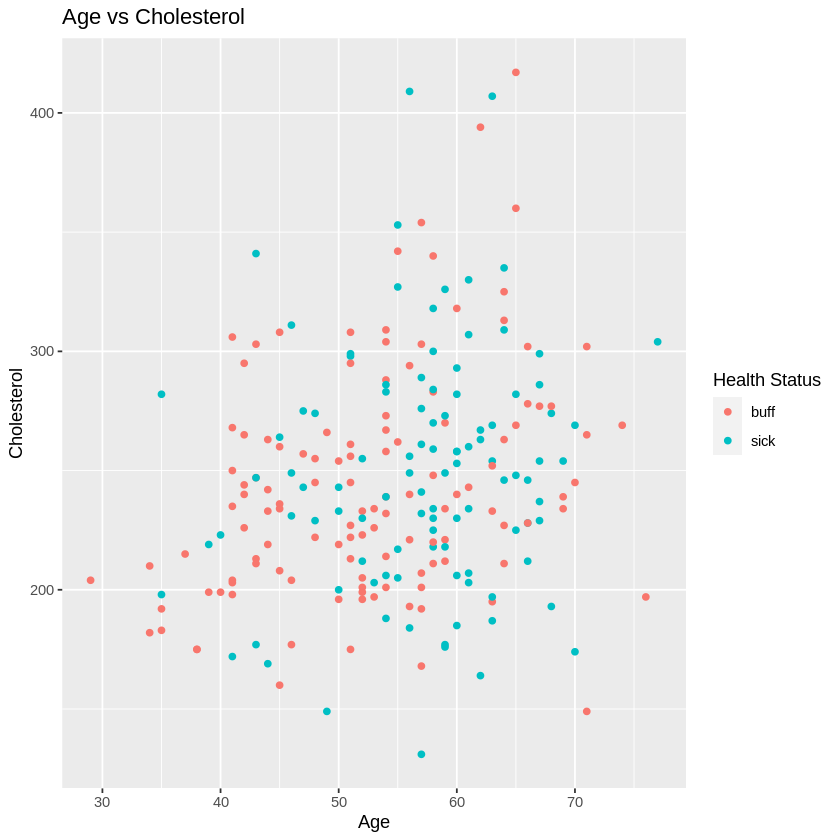

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



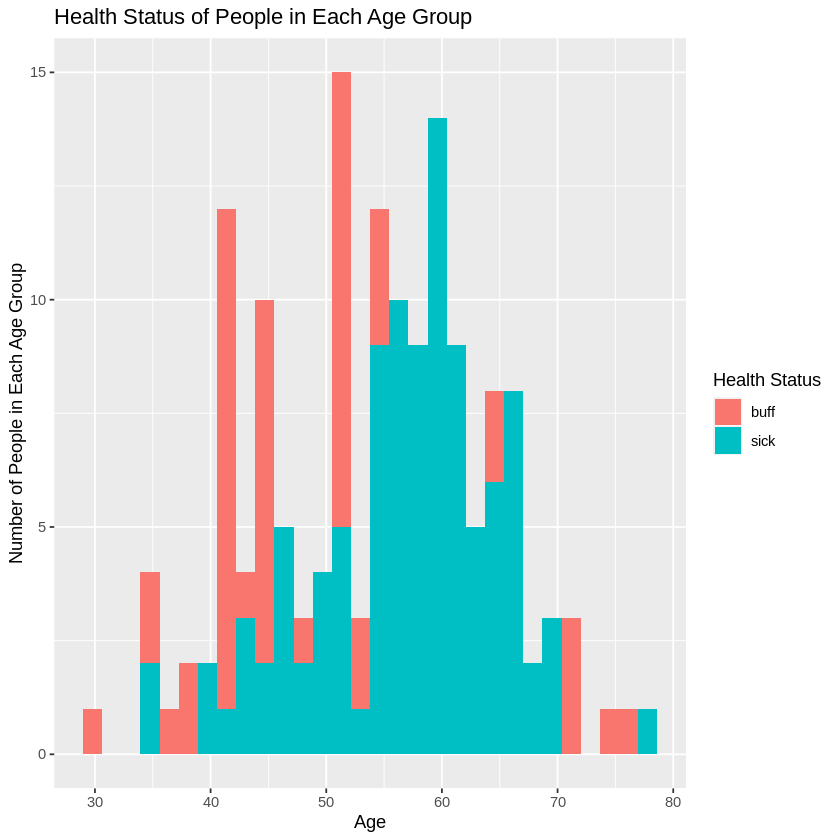

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



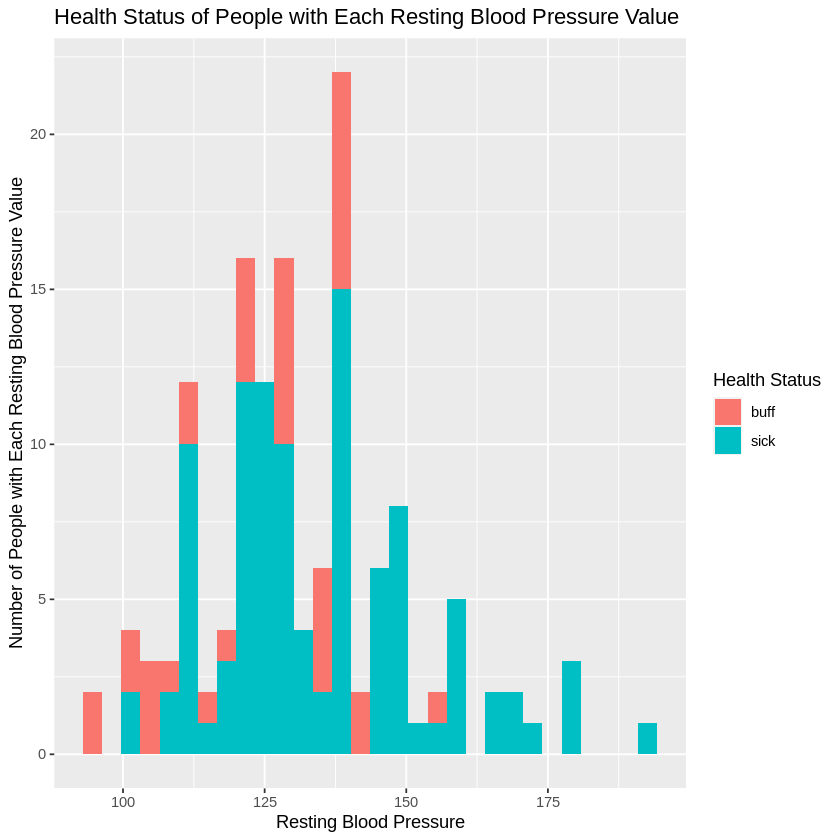

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



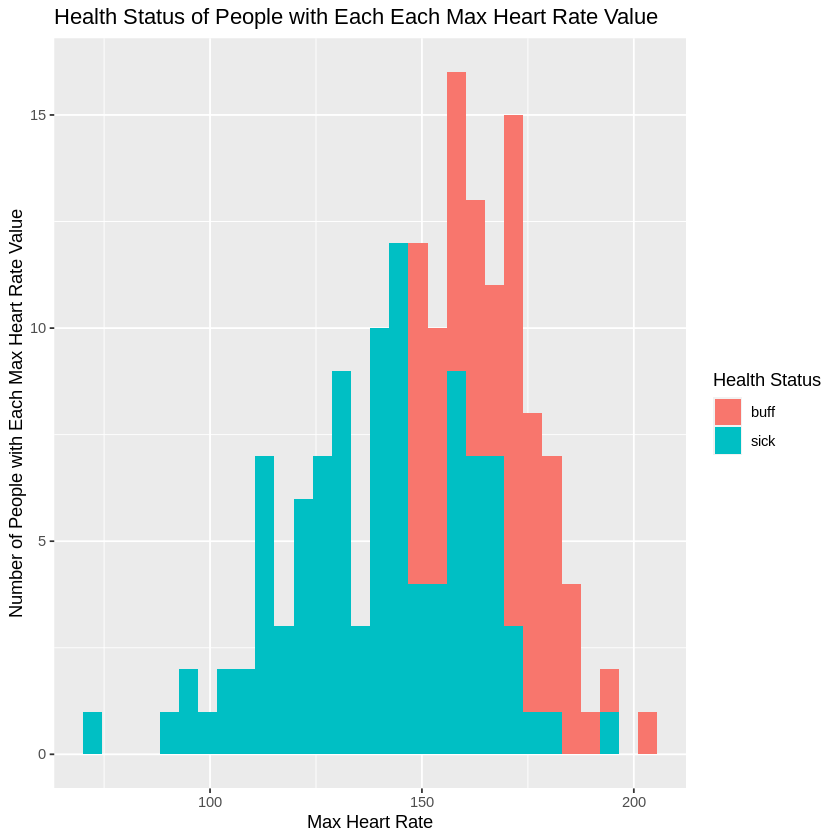

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 5 rows containing non-finite values (stat_bin).”


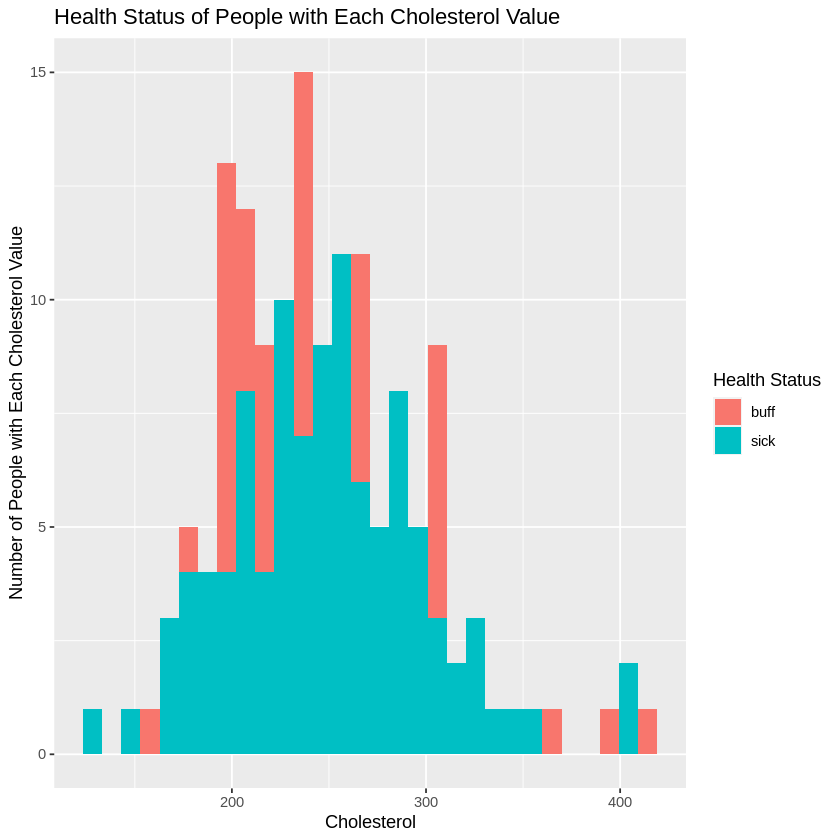

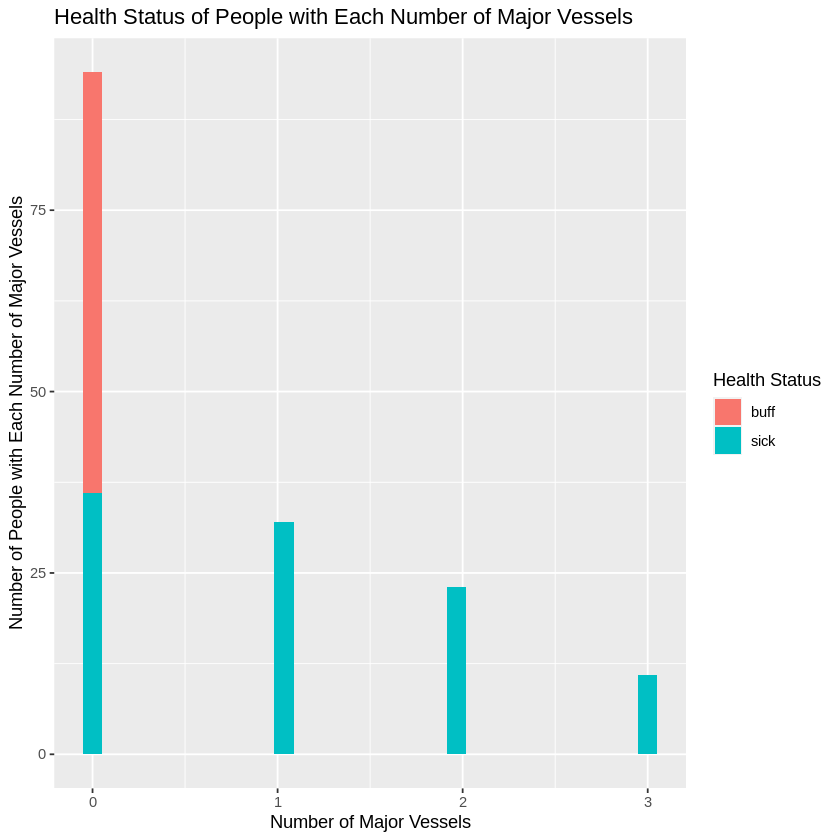

In [25]:
#Visualizing the distribution of two predictor variables with training data.
plot_0 <- clev_train %>%
    ggplot(aes(x=chol, y=max_hr, color=class))+
    geom_point()+
    labs(x="Cholesterol", y="Max Heart Rate", color="Health Status")+
    ggtitle("Cholesterol vs Max Heart Rate")
plot_0

plot_1 <- clev_train %>%
    ggplot(aes(x=age, y=chol, color=class))+
    geom_point()+
    labs(x="Age", y="Cholesterol", color="Health Status")+
    ggtitle("Age vs Cholesterol")
plot_1

plot_2 <- clev_train %>%
    ggplot(aes(x=age, fill=class))+
    geom_histogram(position="identity")+
    labs(x="Age", y="Number of People in Each Age Group", fill="Health Status")+
    ggtitle("Health Status of People in Each Age Group")
plot_2

plot_3 <- clev_train %>%
    ggplot(aes(x=rest_bp, fill=class))+
    geom_histogram(position="identity")+
    labs(x="Resting Blood Pressure", y="Number of People with Each Resting Blood Pressure Value", fill="Health Status")+
    ggtitle("Health Status of People with Each Resting Blood Pressure Value")
plot_3

plot_4 <- clev_train %>%
    ggplot(aes(x=max_hr, fill=class))+
    geom_histogram(position="identity")+
    labs(x="Max Heart Rate", y="Number of People with Each Max Heart Rate Value", fill="Health Status")+
    ggtitle("Health Status of People with Each Each Max Heart Rate Value")
plot_4

plot_5 <- clev_train %>%
    ggplot(aes(x=chol, fill=class))+
    geom_histogram(position="identity")+
    labs(x="Cholesterol", y="Number of People with Each Cholesterol Value", fill="Health Status")+
    ggtitle("Health Status of People with Each Cholesterol Value")
plot_5

plot_6 <- clev_train %>%
    ggplot(aes(x=num_bv, fill=class))+
    geom_histogram(position="identity")+
    labs(x="Number of Major Vessels", y="Number of People with Each Number of Major Vessels", fill="Health Status")+
    ggtitle("Health Status of People with Each Number of Major Vessels")
plot_6

Methods:
We will do a classification to predict if the individual has heart disease or not. The predictors we will be using are cholesterol, number of major blood vessels, maximum heart rate, age, and blood presssure. We are using k-nearest neighbours to do our classification because since there are many predictors, finding the nearest points to the point we are predicting will make the prediction the most accurate. One way we will visualize our results is with a scatterplot that shows the likelihood of heart disease based on certain predictors like maximum heart rate and cholesterol. We hope to find certain predictors that better show the likelihood of heart disease which can help to make it easier to predict it in patients. Futher questions that could come from this are what combinations of two or three predictors show the highest likelihood of heart disease or what combinations are the least accurate. 

Sources

Filate, Woganee A., Helen L. Johansen, Courtney C. Kennedy, and Jack V. Tu. 2003. “Regional Variations in Cardiovascualr Mortality in Canada.” Canadian Journal of Cardiology 11 (19): 1241.

Government of Canada. 2017. “Heart Disease in Canada.” Canada.ca. https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html.

Health Agency of Canada. 2018. “Report from the Canadian Chronic Disease Surveillance System: Heart Disease in Canada.” Canadian Electronic Library/desLibris. https://go.exlibris.link/CPyKsFFV.

Statista. 2021. “Death rate for major cardiovascular diseases in Canada from 2000 to 2019.” https://www.statista.com/statistics/434439/death-rate-for-major-cardiovascular-diseases-in-canada/.
